# Model Analysis and Testing

In [26]:
#!pip install plotly gower dateutil kmodes scikit-learn

In [1]:
import os
import ast
import tempfile
import pickle

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingClassifier
from sklearn import metrics
from scipy.cluster.hierarchy import linkage, fcluster
import gower

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "notebook+plotly_mimetype+png"
# pio.renderers.default = "png"
%matplotlib inline

## Load and format data

In [2]:
# Use normpath to make work on windows machines
data_dir = os.path.normpath("../data/")
eedi_dir = os.path.join(data_dir, "Eedi_dataset")
eedi_metadata_dir = os.path.join(eedi_dir, "metadata")

df_train = pd.read_csv(os.path.join(eedi_dir, "train_data", "train_task_3_4.csv"))
df_answer = pd.read_csv(os.path.join(eedi_metadata_dir, "answer_metadata_task_3_4.csv"), parse_dates=["DateAnswered"])
df_student = pd.read_csv(os.path.join(eedi_metadata_dir, "student_metadata_task_3_4.csv"), parse_dates=["DateOfBirth"])
df_question = pd.read_csv(os.path.join(eedi_metadata_dir, "question_metadata_task_3_4.csv"))
df_subject = pd.read_csv(os.path.join(eedi_metadata_dir, "subject_metadata.csv"))

# Join the datasets on the relevant keys, so that we only have to work with two DFs: df_total and df_subject
df_total = df_train.join(df_answer.set_index('AnswerId'), on="AnswerId")\
                    .join(df_student.set_index("UserId"), on="UserId")\
                    .join(df_question.set_index("QuestionId"), on="QuestionId")

# Convert str col to proper dtype, list of ints
df_total.SubjectId = df_total.SubjectId.apply(ast.literal_eval)
# Convert PremiumPupil to proper dtype of bool
df_total.PremiumPupil = df_total.PremiumPupil.fillna(0).astype(bool)
# Make age column and drop DateOfBirth
df_total["Age"] = df_total.apply(lambda x: relativedelta(x.DateAnswered, x.DateOfBirth).years if not pd.isnull(x.DateOfBirth) else np.NaN, axis=1) 
df_total = df_total.drop(columns=["DateOfBirth"])

subject_mapping = pd.Series(df_subject.Name.values,index=df_subject.SubjectId).to_dict()
# Make 1st level category ID
df_total["Category1"] = df_total.SubjectId.apply(lambda x: subject_mapping[x[1]])
# Make column with strs of the parentId
df_subject["ParentName"] = df_subject.ParentId.map(subject_mapping)


print(df_subject)
df_total

     SubjectId                       Name  ParentId  Level  \
0            3                      Maths       NaN      0   
1           32                     Number       3.0      1   
2           33                     BIDMAS     144.0      3   
3           34     Upper and Lower Bounds     141.0      3   
4           35             Calculator Use      32.0      2   
..         ...                        ...       ...    ...   
383       1982  Mixed operation Fractions      39.0      3   
384       1983               Drawing Axes      54.0      3   
385       1985             Reading Scales      98.0      3   
386       1987             Sorting Shapes     174.0      3   
387       1988           Labelling Shapes     174.0      3   

                            ParentName  
0                                  NaN  
1                                Maths  
2                     Basic Arithmetic  
3              Rounding and Estimating  
4                               Number  
..       

QuestionId  UserId  AnswerId  IsCorrect  CorrectAnswer  AnswerValue  \
0               898    2111    280203          1              2            2   
1               767    3062     55638          1              3            3   
2               165    1156    386475          1              2            2   
3               490    1653    997498          1              4            4   
4               298    3912    578636          1              3            3   
...             ...     ...       ...        ...            ...          ...   
1382722          80    2608     57945          1              2            2   
1382723         707    2549    584230          0              2            1   
1382724         840    5901   1138956          1              1            1   
1382725         794    3854   1151183          0              1            3   
1382726         157    3184   1321883          1              3            3   

               DateAnswered  Confidence  GroupId  QuizId  SchemeOfWorkId  \
0       2019-12-08 17:47:00         NaN       95      86         52562.0   
1       2019-10-27 20:54:00        25.0      115      39         52562.0   
2       2019-10-06 20:16:00         NaN      101      39         52562.0   
3       2020-02-27 17:40:00         NaN       46     115         52562.0   
4       2019-12-27 16:07:00         NaN      314      78         52562.0   
...                     ...         ...      ...     ...             ...   
1382722 2019-11-28 15:22:00         NaN      270      65         52562.0   
1382723 2020-01-06 16:26:00         NaN      269     109         52562.0   
1382724 2020-01-07 07:14:00         NaN      270      66         52562.0   
1382725 2019-12-15 16:32:00         NaN      339       9         52562.0   
1382726 2020-01-07 10:02:00         NaN       27      66         52562.0   

         Gender  PremiumPupil          SubjectId   Age             Category1  
0             2         False    [3, 49, 62, 70]  12.0               Algebra  
1             0         False  [3, 32, 144, 204]   NaN                Number  
2             0         False   [3, 32, 37, 220]   NaN                Number  
3             0         False   [3, 49, 81, 406]   NaN               Algebra  
4             2         False   [3, 71, 74, 180]  11.0  Geometry and Measure  
...         ...           ...                ...   ...                   ...  
1382722       0         False   [3, 32, 42, 211]   NaN                Number  
1382723       2         False   [3, 32, 42, 212]  12.0                Number  
1382724       0         False   [3, 32, 37, 219]   NaN                Number  
1382725       0         False    [3, 49, 62, 70]   NaN               Algebra  
1382726       2         False   [3, 32, 37, 219]  11.0                Number  

[1382727 rows x 16 columns]

In [64]:
df_total.to_csv(os.path.join(data_dir, "eedi_34_data.csv"))

## Clustering

Want to cluster over numerical AND categorical variables. 

* Use kmodes/kprototype [link](https://pypi.org/project/kmodes/)
* Use gower distance: [with hier clustering](http://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad&strip=0&vwsrc=1&referer=medium-parser)
    * [another link w Rand index](https://www.kaggle.com/code/halflingwizard/clustering-categorical-data-using-gower-distance/notebook)

In [29]:
# cat_cols = ["QuestionId", "UserId", "IsCorrect", "DateAnswered", "Confidence", "GroupId", "QuizId", "Gender", "PremiumPupil", "Age"]
# df_cluster = df_total[]

### Clustering using the KPrototypes Algorithm

In [97]:
cat_cols = ["QuestionId", "UserId", "GroupId", "QuizId", "Gender", "IsCorrect", "PremiumPupil", "Age"]
cluster_cols = cat_cols + ["DateAnswered", "Confidence"]

df_cluster = df_total[cluster_cols].sample(frac=0.01, random_state=42, replace=False).fillna(0)
df_cluster.DateAnswered = df_cluster.DateAnswered.dt.strftime("%Y%m%d").astype(int)

kprot = KPrototypes(n_clusters=3)
df_cluster["Clusters_Kprot"]  = kprot.fit_predict(df_cluster, categorical=list(range(len(cat_cols))))
kprot

KPrototypes(gamma=1146.5278858678553, n_clusters=3)

In [98]:
df_cluster

QuestionId  UserId  GroupId  QuizId  Gender  IsCorrect  PremiumPupil  \
379087          207    6032      104      78       1          1         False   
1026777         130    2956      153      55       2          1         False   
1347837          20    4471      275     105       0          1         False   
630173          868    4602      118       9       0          0         False   
363588          238      98      123      62       0          1         False   
...             ...     ...      ...     ...     ...        ...           ...   
977564          448     485       91      32       0          0         False   
688113          138    3691      149       9       1          1         False   
922974          877     550       27      55       1          1          True   
334761          119     445      350      84       1          0         False   
354966          106    5429      289      59       1          0         False   

          Age  DateAnswered  Confidence  Clusters  
379087   11.0      20200102         0.0         1  
1026777   0.0      20200304         0.0         0  
1347837   0.0      20200210         0.0         1  
630173    0.0      20200116         0.0         1  
363588    0.0      20200428         0.0         0  
...       ...           ...         ...       ...  
977564    0.0      20191028         0.0         2  
688113   11.0      20191125        75.0         2  
922974   11.0      20200312         0.0         0  
334761   11.0      20191217         0.0         2  
354966   12.0      20200127        75.0         1  

[13827 rows x 11 columns]

In [100]:
df_total["Clusters_Kprot"] = np.NaN
df_total.loc[df_cluster.index, "Clusters_Kprot"] = df_cluster["Clusters"]

# df_total.loc[df_cluster.index, "Clusters_K"]
df_total.Clusters_Kprot.value_counts()

Clusters_Kprot
2.0    7357
1.0    4137
0.0    2333
Name: count, dtype: int64

In [106]:
df_cluster

QuestionId  UserId  GroupId  QuizId  Gender  IsCorrect  PremiumPupil  \
379087          207    6032      104      78       1          1         False   
1026777         130    2956      153      55       2          1         False   
1347837          20    4471      275     105       0          1         False   
630173          868    4602      118       9       0          0         False   
363588          238      98      123      62       0          1         False   
...             ...     ...      ...     ...     ...        ...           ...   
977564          448     485       91      32       0          0         False   
688113          138    3691      149       9       1          1         False   
922974          877     550       27      55       1          1          True   
334761          119     445      350      84       1          0         False   
354966          106    5429      289      59       1          0         False   

          Age  DateAnswered  Confidence  Clusters_Kprot  Clusters_g_scipy  
379087   11.0      20200102         0.0               1                 2  
1026777   0.0      20200304         0.0               0                 2  
1347837   0.0      20200210         0.0               1                 2  
630173    0.0      20200116         0.0               1                 1  
363588    0.0      20200428         0.0               0                 2  
...       ...           ...         ...             ...               ...  
977564    0.0      20191028         0.0               2                 1  
688113   11.0      20191125        75.0               2                 2  
922974   11.0      20200312         0.0               0                 2  
334761   11.0      20191217         0.0               2                 1  
354966   12.0      20200127        75.0               1                 1  

[13827 rows x 12 columns]

### Clustering using the Gower distance matrix

Gower Similarity is computed as the average of partial similarities (ps) across the m features of the observation, and can be used to calculate non-euclidian (aka more correct) distances between categorical features. 

In [104]:
# cat_cols = ["QuestionId", "UserId", "GroupId", "QuizId", "Gender", "IsCorrect", "PremiumPupil", "Age"]
# cluster_cols = cat_cols + ["DateAnswered", "Confidence"]

# df_cluster = df_total[cluster_cols].sample(frac=0.1, random_state=42).fillna(0)
# df_cluster.DateAnswered = df_cluster.DateAnswered.dt.strftime("%Y%m%d").astype(int)

gower_dists = gower.gower_matrix(df_cluster.drop(columns=["Clusters_Kprot"], errors="ignore"), 
                                 cat_features = [True] * len(cat_cols) + [False] * (len(cluster_cols) - len(cat_cols)))

gower_dists

array([[0.        , 0.60210603, 0.601126  , ..., 0.50218946, 0.592635  ,
        0.67526066],
       [0.60210603, 0.        , 0.50098   , ..., 0.6000834 , 0.79474103,
        0.7768454 ],
       [0.601126  , 0.50098   , 0.        , ..., 0.70106345, 0.79376096,
        0.7758654 ],
       ...,
       [0.50218946, 0.6000834 , 0.70106345, ..., 0.        , 0.6948244 ,
        0.7769288 ],
       [0.592635  , 0.79474103, 0.79376096, ..., 0.6948244 , 0.        ,
        0.6678956 ],
       [0.67526066, 0.7768454 , 0.7758654 , ..., 0.7769288 , 0.6678956 ,
        0.        ]], dtype=float32)

#### Gower with scipy fcluster

In [105]:
cluster_linkages = linkage(gower_dists) 
clusters = fcluster(cluster_linkages, t=3, criterion='maxclust')

df_cluster["Clusters_g_scipy"] = clusters

C:\Users\Bhavana\AppData\Local\Temp\ipykernel_29252\1462709787.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



#### Gower with sklearn AgglomerativeClustering

In [111]:
# Memory of computing ~100K clustering too much, need to provide temp dir
with tempfile.TemporaryDirectory() as dir:
    model_single = AgglomerativeClustering(n_clusters=3, linkage='single', metric='precomputed', memory=dir)
    clusters_lsingle = model_single.fit_predict(gower_dists)
df_cluster["Clusters_g_ls"] = clusters_lsingle

with tempfile.TemporaryDirectory() as dir:
    model_single = AgglomerativeClustering(n_clusters=3, linkage='average', metric='precomputed', memory=dir)
    clusters_lavg = model_single.fit_predict(gower_dists)
df_cluster["Clusters_g_la"] = clusters_lavg

with tempfile.TemporaryDirectory() as dir:
    model_single = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='precomputed', memory=dir)
    clusters_lcomplete = model_single.fit_predict(gower_dists)
df_cluster["Clusters_g_lc"] = clusters_lcomplete

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\cluster\_agglomerative.py:1071: UserWarning:

Persisting input arguments took 0.70s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\cluster\_agglomerative.py:1071: UserWarning:

Persisting input arguments took 0.69s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\cluster\_agglomerative.py:1071: UserWarning:

Persisting input arguments took 0.70s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases)

In [132]:
# print(df_cluster["Clusters_g_ls"].value_counts(), df_cluster["Clusters_g_la"].value_counts(), df_cluster["Clusters_g_lc"].value_counts())
df_cluster
# pd.DataFrame(df_total[cluster_cols].drop(columns="DateAnswered").value_counts(dropna=False)).reset_index()

QuestionId  UserId  GroupId  QuizId  Gender  IsCorrect  PremiumPupil  \
379087          207    6032      104      78       1          1         False   
1026777         130    2956      153      55       2          1         False   
1347837          20    4471      275     105       0          1         False   
630173          868    4602      118       9       0          0         False   
363588          238      98      123      62       0          1         False   
...             ...     ...      ...     ...     ...        ...           ...   
977564          448     485       91      32       0          0         False   
688113          138    3691      149       9       1          1         False   
922974          877     550       27      55       1          1          True   
334761          119     445      350      84       1          0         False   
354966          106    5429      289      59       1          0         False   

          Age  DateAnswered  Confidence  Clusters_Kprot  Clusters_g_scipy  \
379087   11.0      20200102         0.0               1                 2   
1026777   0.0      20200304         0.0               0                 2   
1347837   0.0      20200210         0.0               1                 2   
630173    0.0      20200116         0.0               1                 1   
363588    0.0      20200428         0.0               0                 2   
...       ...           ...         ...             ...               ...   
977564    0.0      20191028         0.0               2                 1   
688113   11.0      20191125        75.0               2                 2   
922974   11.0      20200312         0.0               0                 2   
334761   11.0      20191217         0.0               2                 1   
354966   12.0      20200127        75.0               1                 1   

         Clusters_g_ls  Clusters_g_la  Clusters_g_lc             Category1  
379087               0              2              2  Geometry and Measure  
1026777              0              1              1  Geometry and Measure  
1347837              0              1              1  Geometry and Measure  
630173               0              1              1               Algebra  
363588               0              1              1                Number  
...                ...            ...            ...                   ...  
977564               0              1              1                Number  
688113               0              2              2               Algebra  
922974               0              2              0               Algebra  
334761               0              2              2               Algebra  
354966               0              0              1  Geometry and Measure  

[13827 rows x 16 columns]

### Save clustering values

In [120]:
df_cluster["Category1"] = df_total.loc[df_cluster.index]["Category1"].astype("category")
df_cluster.to_csv(os.path.join(data_dir, "Output", "cluster_results_smaller.csv"))

# np.save(os.path.join(data_dir, "Output", "gower_dists.npy"), gower_dists)

In [9]:
df_cluster = pd.read_csv(os.path.join(data_dir, "Output", "cluster_results_smaller.csv"), index_col=0)
df_cluster["Category1"] = df_cluster["Category1"].astype("category").cat.codes

### Rand Index Comparison

In [145]:
# df_cluster
# np.fromfunction(lambda x: x[0] + x[1], (6, 6), dtype=float)
df_cluster.columns[10:]

Index(['Clusters_Kprot', 'Clusters_g_scipy', 'Clusters_g_ls', 'Clusters_g_la',
       'Clusters_g_lc', 'Category1'],
      dtype='object')

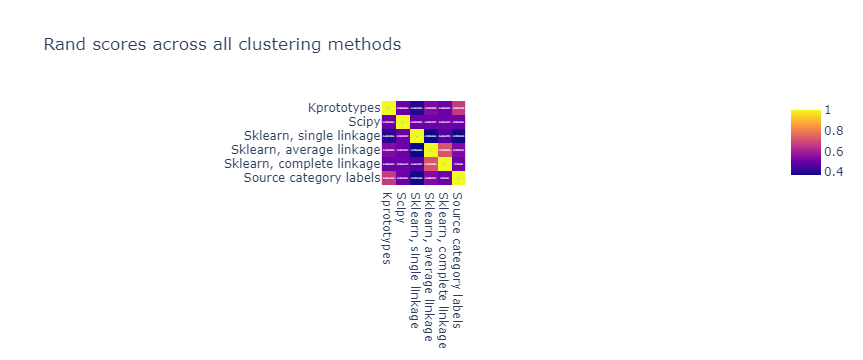

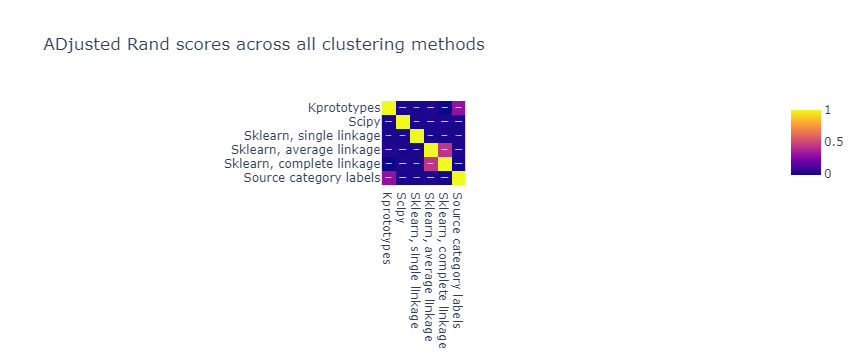

In [10]:
df_cluster["Category1"] = df_cluster["Category1"].astype("category").cat.codes

def rand_score_from_ind(i1, i2, adj=False):
    if adj:
        return metrics.adjusted_rand_score(df_cluster.iloc[:, 10+i1], df_cluster.iloc[:, 10+i2])
    else:
        return metrics.rand_score(df_cluster.iloc[:, 10+i1], df_cluster.iloc[:, 10+i2])
        
colnames = [
    "Kprototypes",
    "Scipy",
    "Sklearn, single linkage",
    "Sklearn, average linkage",
    "Sklearn, complete linkage",
    "Source category labels"
    ]

rands = [[rand_score_from_ind(i1, i2) for i2 in range(6)] for i1 in range(6)]
df_rands = pd.DataFrame(rands, index=colnames, columns=colnames)

adj_rands = [[rand_score_from_ind(i1, i2, adj=True) for i2 in range(6)] for i1 in range(6)]
df_adj_rands = pd.DataFrame(adj_rands, index=colnames, columns=colnames)

fig = px.imshow(df_rands, text_auto=True, title="Rand scores across all clustering methods")
fig.show()

fig = px.imshow(df_adj_rands, text_auto=True, title="ADjusted Rand scores across all clustering methods")
fig.show()



## Logistic Regression

[link](https://www.justintodata.com/logistic-regression-example-in-python/)

### Make data for supervised learning models

In [3]:
def minmaxnorm(col):
    return (col - col.min())/(col.max()-col.min())

## Make DF for use with supervised learning models
cat_cols = ["Gender",  "Age", "Category1"]
scale_cols = ["QuestionId", "UserId", "GroupId", "QuizId", "DateAnswered"]
reg_cols = cat_cols + scale_cols + ["Confidence", "PremiumPupil", "IsCorrect"]
df_reg = df_total[reg_cols].fillna(0).astype({c:"category" for c in cat_cols})
df_reg.DateAnswered = df_reg.DateAnswered.dt.strftime("%Y%m%d").astype(int)
# Min-max normalization
for c in scale_cols:
    df_reg[c] = minmaxnorm(df_reg[c])
df_reg = pd.get_dummies(df_reg, columns=cat_cols , dtype=int)
# Move target column to end
cols = list(df_reg.columns)
cols.append(cols.pop(7))
df_reg = df_reg[cols]

reg_train, reg_test = train_test_split(df_reg, train_size=0.9, random_state=42, stratify=df_reg["IsCorrect"])

In [26]:
# pd.get_dummies(df_reg, columns=["Gender", "Age", "Category1"] , dtype=int)
# df_reg[list(df_reg.columns) + ["IsCorrect"]]

reg_train

QuestionId    UserId   GroupId    QuizId  DateAnswered  Confidence  \
112756     0.791975  0.570127  0.136247  0.252101      0.979364         0.0   
1029526    0.099261  0.480150  0.419023  0.302521      0.961126         0.0   
477381     0.090813  0.658314  0.483290  0.411765      0.969463         0.0   
950700     0.819430  0.821022  0.652956  0.462185      0.980094         0.0   
1200436    0.729673  0.717052  0.411311  0.630252      0.010839         0.0   
...             ...       ...       ...       ...           ...         ...   
1163265    0.732841  0.170192  0.480720  0.941176      0.991767         0.0   
641727     0.659979  0.990888  0.946015  0.932773      0.969151         0.0   
982201     0.796199  0.843150  0.619537  0.521008      0.032308        50.0   
347054     0.240760  0.324601  0.570694  0.647059      0.971652         0.0   
1174818    0.014784  0.833550  0.825193  0.773109      0.969776         0.0   

         PremiumPupil  Gender_0  Gender_1  Gender_2  ...  Age_12.0  Age_13.0  \
112756          False         0         0         1  ...         1         0   
1029526         False         0         1         0  ...         0         0   
477381          False         1         0         0  ...         0         0   
950700          False         0         0         1  ...         1         0   
1200436         False         1         0         0  ...         0         0   
...               ...       ...       ...       ...  ...       ...       ...   
1163265         False         0         1         0  ...         1         0   
641727          False         0         1         0  ...         0         0   
982201          False         1         0         0  ...         0         0   
347054          False         1         0         0  ...         0         0   
1174818          True         0         1         0  ...         0         0   

         Age_14.0  Age_15.0  Age_16.0  Age_38.0  Category1_Algebra  \
112756          0         0         0         0                  0   
1029526         0         0         0         0                  0   
477381          0         0         0         0                  0   
950700          0         0         0         0                  1   
1200436         0         0         0         0                  0   
...           ...       ...       ...       ...                ...   
1163265         0         0         0         0                  0   
641727          0         0         0         0                  0   
982201          0         0         0         0                  0   
347054          0         0         0         0                  1   
1174818         0         0         0         0                  0   

         Category1_Geometry and Measure  Category1_Number  IsCorrect  
112756                                1                 0          1  
1029526                               1                 0          1  
477381                                0                 1          1  
950700                                0                 0          0  
1200436                               1                 0          0  
...                                 ...               ...        ...  
1163265                               0                 1          0  
641727                                1                 0          1  
982201                                0                 1          1  
347054                                0                 0          0  
1174818                               1                 0          1  

[1244454 rows x 25 columns]

In [59]:
# df_reg.iloc[:, :-1]
reg = LogisticRegression(penalty=None, solver="newton-cholesky", max_iter=150, n_jobs=6, tol=0.00001)
reg.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

LogisticRegression(max_iter=150, n_jobs=6, penalty=None,
                   solver='newton-cholesky', tol=1e-05)

In [60]:
print(reg.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))
# reg.get_params(deep=True)
score = reg.predict(reg_test.iloc[:, :-1])
print(sum(score == reg_test["IsCorrect"])/len(score))

0.5703137995125585
0.5703137995125585


### Evaluate Performance of Logistic Regression

In [ ]:
metrics.RocCurveDisplay.from_estimator(reg, reg_test.iloc[:, :-1], reg_test["IsCorrect"])
metrics.ConfusionMatrixDisplay.from_estimator(reg, reg_test.iloc[:, :-1], reg_test["IsCorrect"])
metrics.PrecisionRecallDisplay.from_estimator(reg, reg_test.iloc[:, :-1], reg_test["IsCorrect"])

## Other Supervised Learning Models

In [64]:
perceptron = Perceptron(n_jobs=6)
perceptron.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

Perceptron(n_jobs=6)

In [66]:
print(perceptron.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.47190702450948485


In [27]:
svc = LinearSVC(dual=False, max_iter=2000)
svc.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

LinearSVC(dual=False, max_iter=2000)

In [31]:
svc.n_iter_

12

In [28]:
print(svc.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.5703354957222306


In [38]:
svm = SGDClassifier(n_jobs=6, penalty=None, max_iter=2000)
svm.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

SGDClassifier(max_iter=2000, n_jobs=6, penalty=None)

In [39]:
print(svm.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.5638266328205795


## Random Forest Regression

https://towardsdatascience.com/random-forest-regression-5f605132d19d

In [83]:
dtree = DecisionTreeClassifier()
dtree.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

DecisionTreeClassifier()

In [87]:
print(dtree.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))
# plot_tree(dtree)

0.6100250952825208


In [88]:
forest = RandomForestClassifier(n_jobs=6)
forest.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

RandomForestClassifier(n_jobs=6)

In [89]:
print(forest.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.6522893117239085


In [91]:
bagg = BaggingClassifier(n_jobs=6)
bagg.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

BaggingClassifier()

In [92]:
print(bagg.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.6450283135536222


In [95]:
hgb = HistGradientBoostingClassifier()
hgb.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])

HistGradientBoostingClassifier()

In [96]:
print(hgb.score(reg_test.iloc[:, :-1], reg_test["IsCorrect"]))

0.6610835087110282


### Re-run best performing on non-transformed data
`sklearn.ensemble.HistGradientBoostingClassifier`

[link](https://machinelearningmastery.com/histogram-based-gradient-boosting-ensembles/)

In [4]:
## Make DF for use with HistGradientBoostingClassifier
cat_cols = ["Gender",  "Age", "Category1", "QuizId"]
model_cols = cat_cols + ["QuestionId", "UserId", "GroupId", "DateAnswered", "Confidence", "PremiumPupil", "IsCorrect"]
df_model = df_total[model_cols].astype({c:"category" for c in cat_cols})

df_model["Category1"] = df_model["Category1"].cat.codes
df_model.DateAnswered = df_model.DateAnswered.dt.strftime("%Y%m%d").astype(int)

model_train, model_test = train_test_split(df_model, train_size=0.9, random_state=42, stratify=df_model["IsCorrect"])

In [5]:
model_train

Gender   Age  Category1 QuizId  QuestionId  UserId  GroupId  \
112756       2  12.0          1     30         750    3505       53   
1029526      1  11.0          1     36          94    2952      163   
477381       0   NaN          2     49          86    4047      188   
950700       2  12.0          0     55         776    5047      254   
1200436      0   NaN          1     75         691    4408      160   
...        ...   ...        ...    ...         ...     ...      ...   
1163265      1  12.0          2    112         694    1047      187   
641727       1   NaN          1    111         625    6091      368   
982201       0   NaN          2     62         754    5183      241   
347054       0   NaN          0     77         228    1996      222   
1174818      1  11.0          1     92          14    5124      321   

         DateAnswered  Confidence  PremiumPupil  IsCorrect  
112756       20200303         NaN         False          1  
1029526      20200128         NaN         False          1  
477381       20200208         NaN         False          1  
950700       20200310         NaN         False          0  
1200436      20191010         0.0         False          0  
...               ...         ...           ...        ...  
1163265      20200422         NaN         False          0  
641727       20200205         NaN         False          1  
982201       20191216        50.0         False          1  
347054       20200229         NaN         False          0  
1174818      20200211         NaN          True          1  

[1244454 rows x 11 columns]

In [15]:
hgb2 = HistGradientBoostingClassifier(categorical_features=cat_cols, max_iter=1000, max_leaf_nodes=80)
hgb2.fit(X=model_train.iloc[:, :-1], y=model_train["IsCorrect"])

HistGradientBoostingClassifier(categorical_features=['Gender', 'Age',
                                                     'Category1', 'QuizId'],
                               max_iter=1000, max_leaf_nodes=80)

In [17]:
print(hgb2.score(model_test.iloc[:, :-1], model_test["IsCorrect"]))

0.7145863617626


In [57]:
# print(metrics.accuracy_score(model_test["IsCorrect"], hgb2.predict(model_test.iloc[:, :-1])))
# print(metrics.balanced_accuracy_score(model_test["IsCorrect"], hgb2.predict(model_test.iloc[:, :-1])))
# print(metrics.f1_score(model_test["IsCorrect"], hgb2.predict(model_test.iloc[:, :-1])))
# print(metrics.precision_recall_fscore_support(model_test["IsCorrect"], hgb2.predict(model_test.iloc[:, :-1])))

perf_values = metrics.classification_report(model_test["IsCorrect"], hgb2.predict(model_test.iloc[:, :-1]), output_dict=True)
perf_values

{'0': {'precision': 0.6886255194705249,
  'recall': 0.6993356779992185,
  'f1-score': 0.6939392764356896,
  'support': 63975.0},
 '1': {'precision': 0.7375960056205066,
  'recall': 0.7277181081590353,
  'f1-score': 0.7326237627116348,
  'support': 74298.0},
 'accuracy': 0.7145863617626,
 'macro avg': {'precision': 0.7131107625455158,
  'recall': 0.7135268930791269,
  'f1-score': 0.7132815195736621,
  'support': 138273.0},
 'weighted avg': {'precision': 0.7149387489511274,
  'recall': 0.7145863617626,
  'f1-score': 0.7147255467945463,
  'support': 138273.0}}

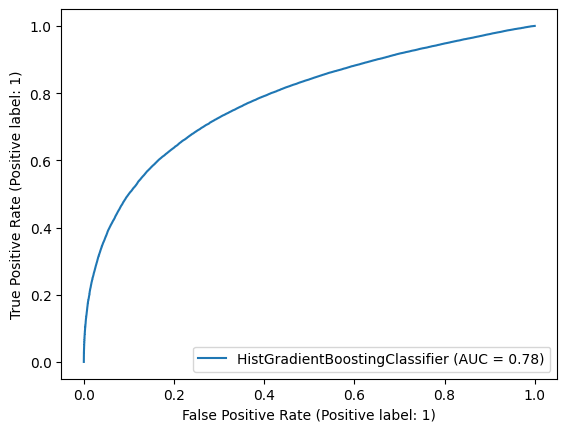

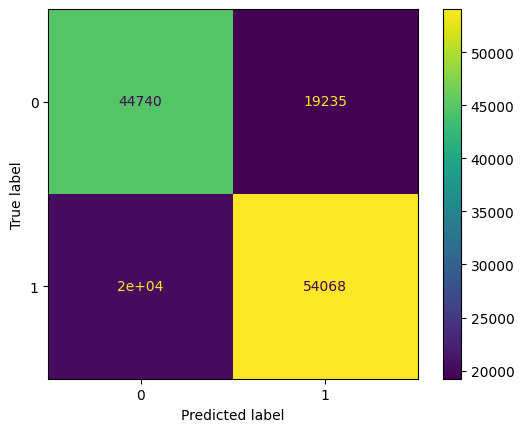

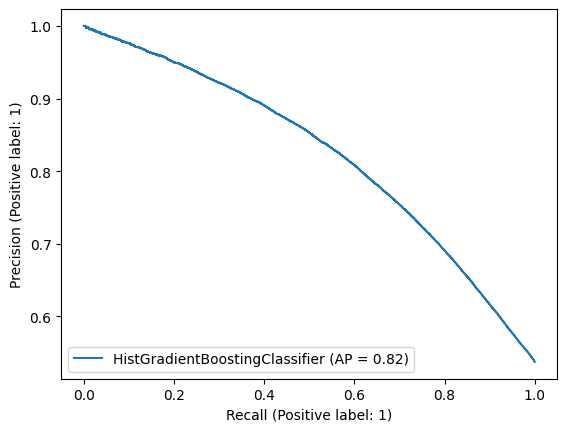

In [20]:
metrics.RocCurveDisplay.from_estimator(hgb2, model_test.iloc[:, :-1], model_test["IsCorrect"])
metrics.ConfusionMatrixDisplay.from_estimator(hgb2, model_test.iloc[:, :-1], model_test["IsCorrect"])
metrics.PrecisionRecallDisplay.from_estimator(hgb2, model_test.iloc[:, :-1], model_test["IsCorrect"])

## Run and save selected models output

{'Model': 'LogisticRegression', 'Accuracy': 0.5702776391631049, 'precision': 0.5662287587969861, 'recall': 0.5702776391631049, 'f1-score': 0.5600774281244723, 'support': 138273.0, 'TrainIters': array([0])}
{'Model': 'Perceptron', 'Accuracy': 0.47190702450948485, 'precision': 0.45653809962875325, 'recall': 0.47190702450948485, 'f1-score': 0.45496988708654384, 'support': 138273.0, 'LossFcn': 'perceptron', 'TrainIters': 11}
{'Model': 'LinearSVC', 'Accuracy': 0.5703354957222306, 'precision': 0.5662872535880198, 'recall': 0.5703354957222306, 'f1-score': 0.5598867715919607, 'support': 138273.0, 'LossFcn': 'squared_hinge', 'TrainIters': 12}
{'Model': 'SGDClassifier', 'Accuracy': 0.5695399680342511, 'precision': 0.5655460744287035, 'recall': 0.5695399680342511, 'f1-score': 0.5549985711855502, 'support': 138273.0, 'LossFcn': 'log_loss', 'TrainIters': 41}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6107699984812653, 'precision': 0.6107380053352678, 'recall': 0.6107699984812653, 'f1-score':

C:\Users\Bhavana\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\utils\_plotting.py:21: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



{'Model': 'HistGradientBoostingClassifier', 'Accuracy': 0.6602011961843599, 'precision': 0.6599690696501006, 'recall': 0.6602011961843599, 'f1-score': 0.6600696727565298, 'support': 138273.0, 'LossFcn': 'log_loss'}
{'Model': 'HistGradientBoostingClassifier', 'Accuracy': 0.7144127920852227, 'precision': 0.7147235893799919, 'recall': 0.7144127920852227, 'f1-score': 0.7145386521527941, 'support': 138273.0, 'LossFcn': 'log_loss'}


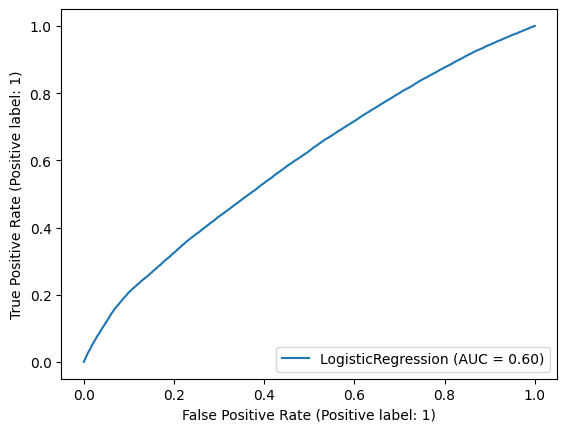

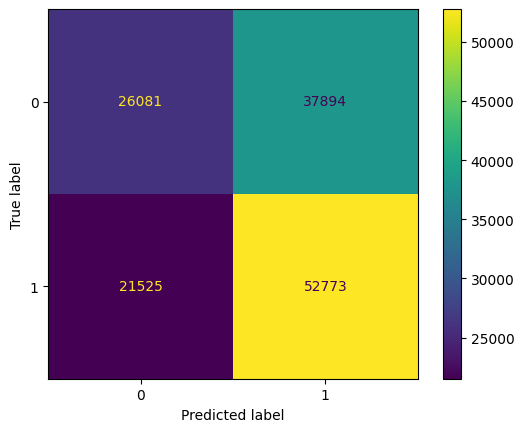

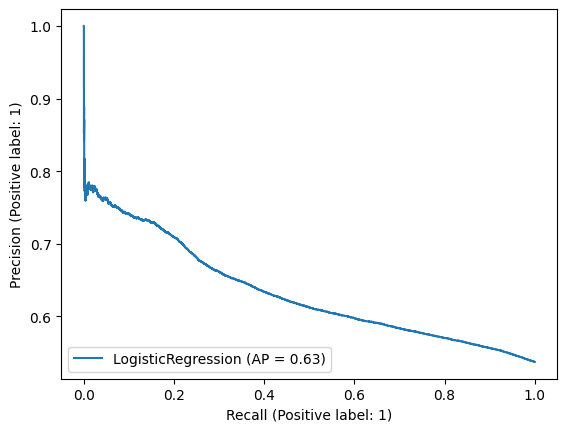

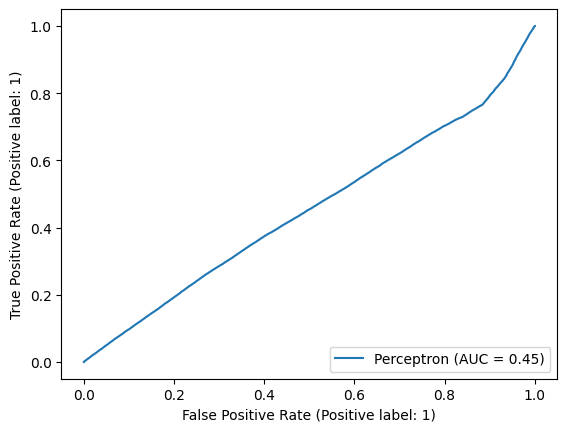

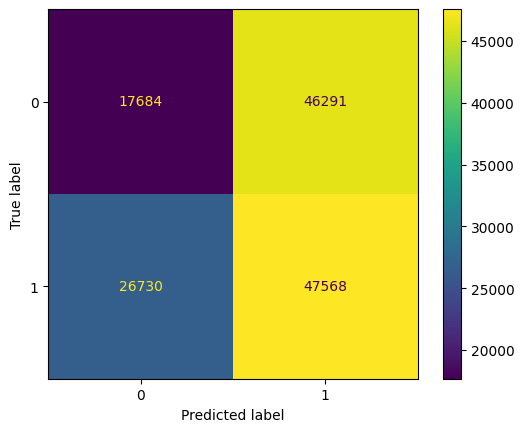

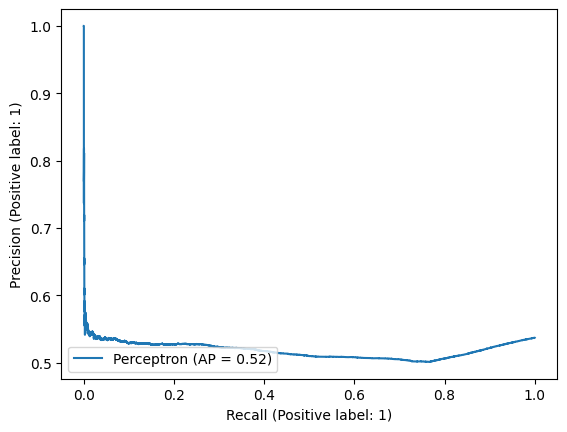

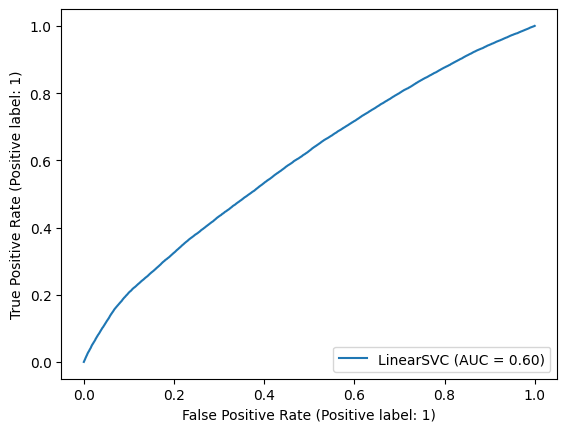

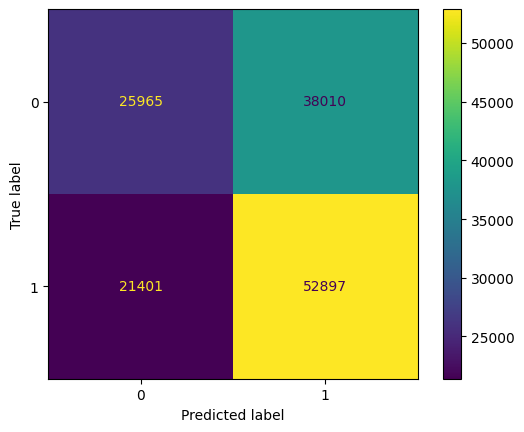

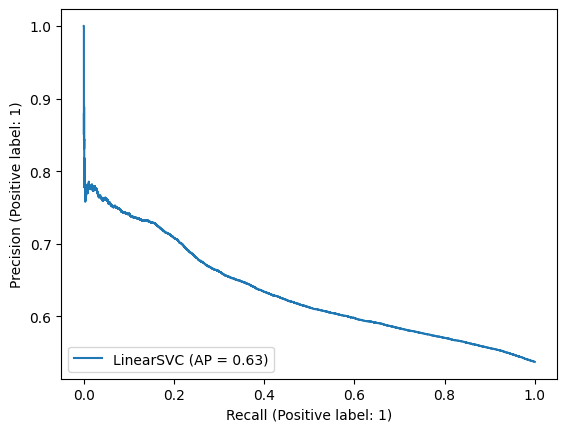

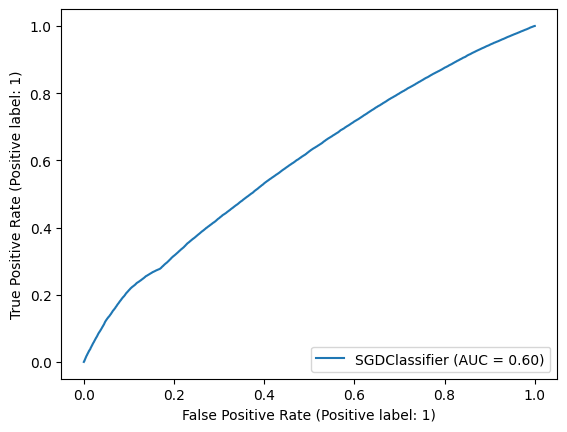

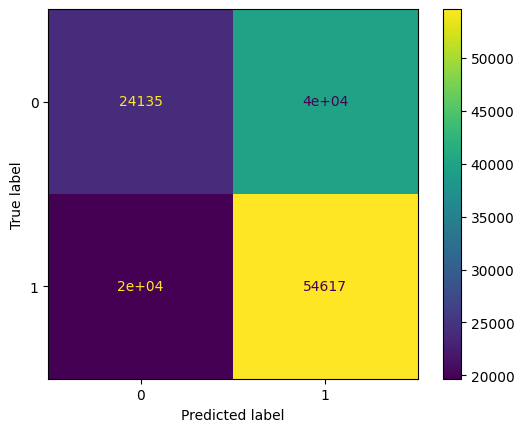

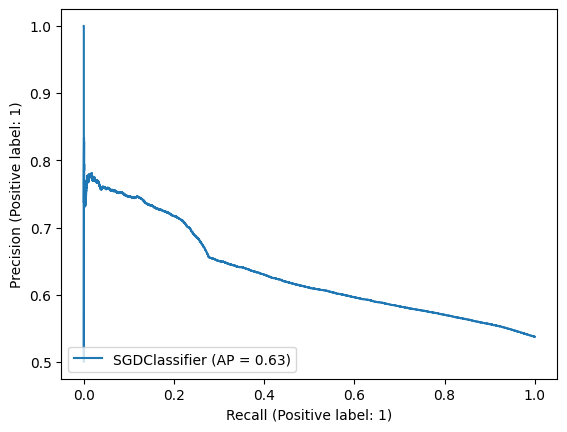

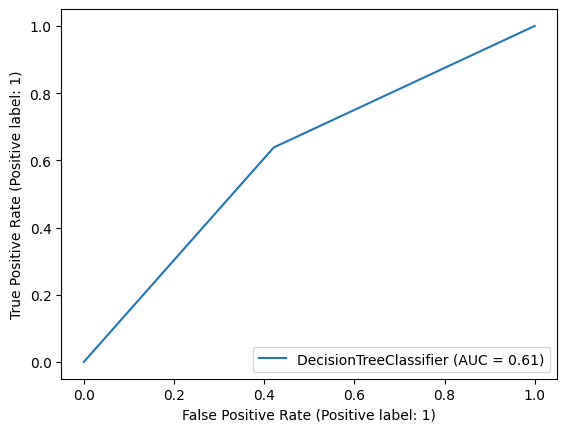

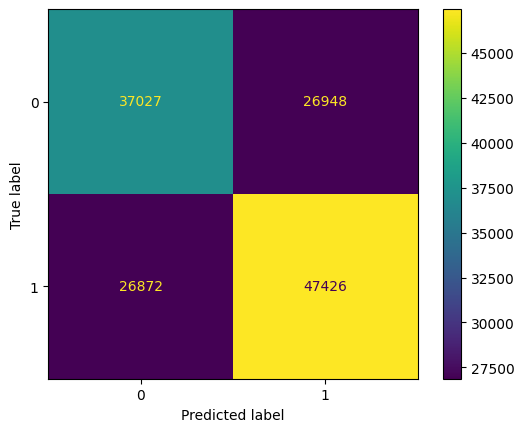

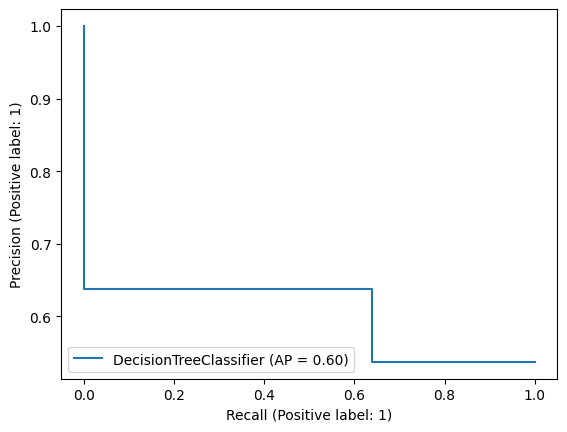

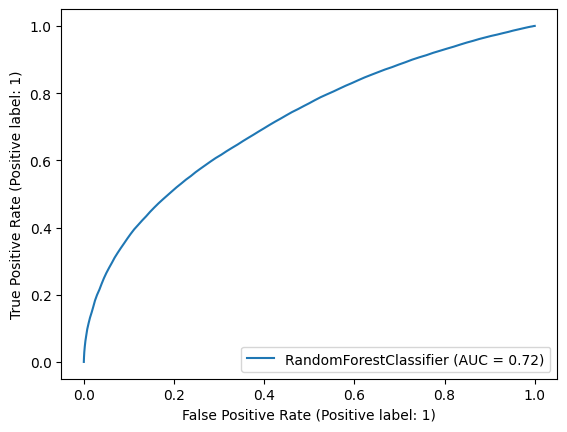

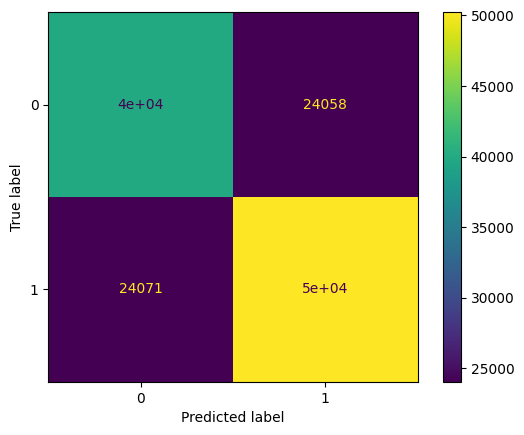

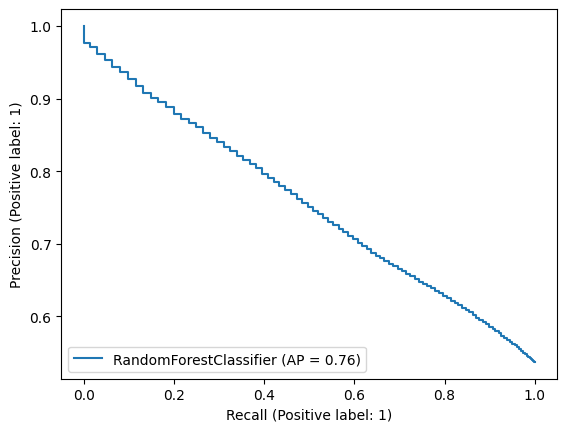

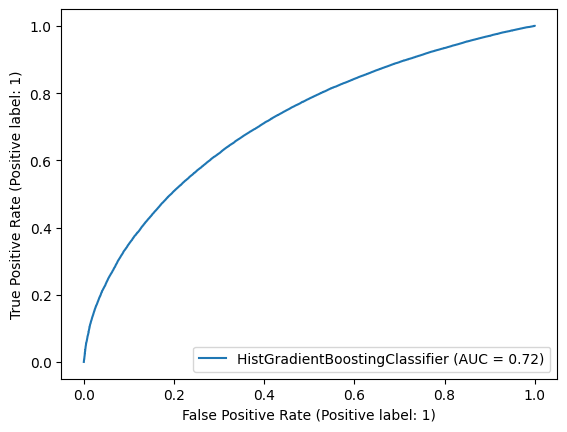

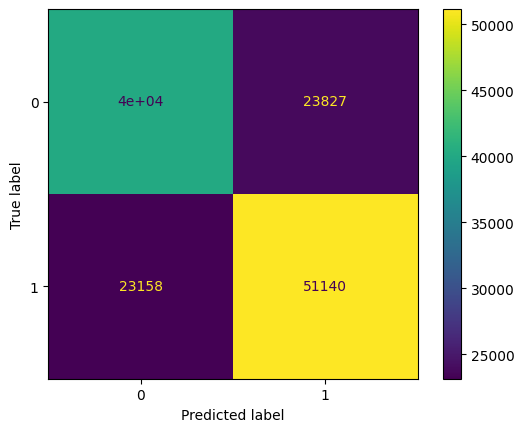

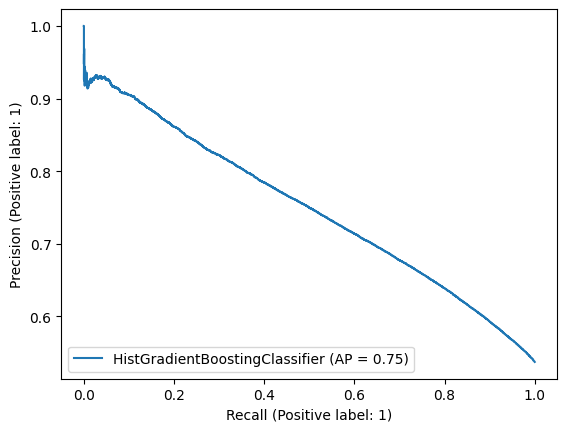

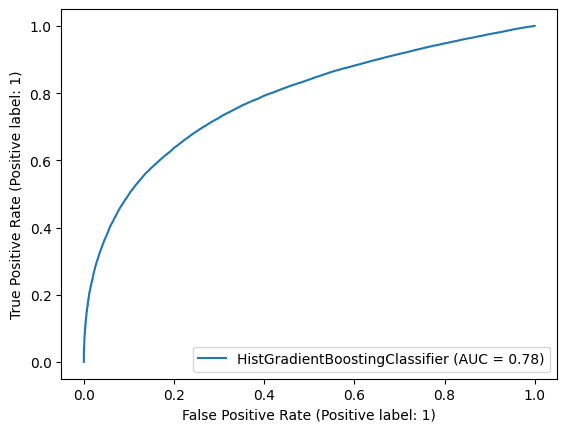

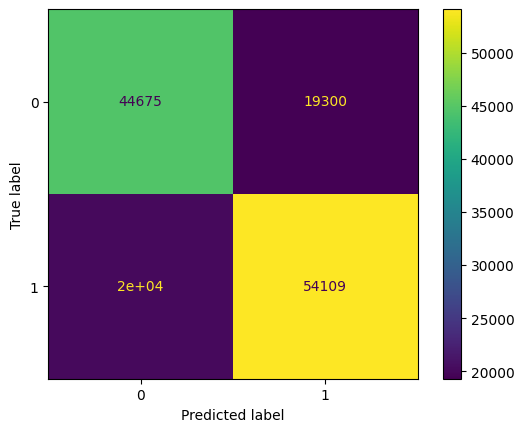

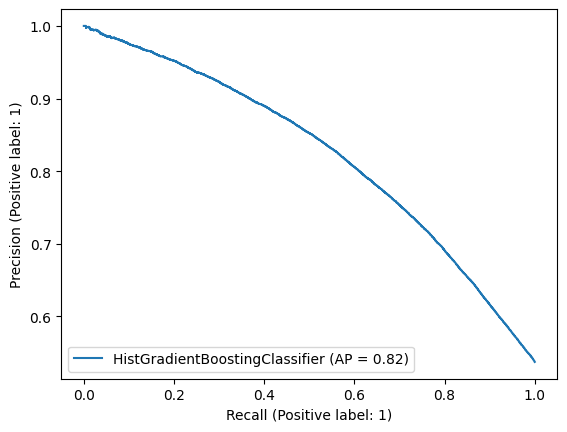

In [6]:
# Uses one hot encoded cats and normalized numbers, reg_train and reg_test
perceptron = Perceptron(n_jobs=6, max_iter=2000)
reg = LogisticRegression(penalty=None, solver="newton-cholesky", max_iter=2000, n_jobs=6, tol=0.00001)
svc = LinearSVC(dual=False, max_iter=2000)
sgd = SGDClassifier(n_jobs=6, loss="log_loss", penalty=None, max_iter=2000)
dtree = DecisionTreeClassifier()
forest = RandomForestClassifier(n_jobs=6)
hgb = HistGradientBoostingClassifier()

models = [reg, perceptron, svc, sgd, dtree, forest, hgb]
model_data = []
model_plots = {}
for model in models:
    model.fit(X=reg_train.iloc[:, :-1], y=reg_train["IsCorrect"])
    perf = metrics.classification_report(reg_test["IsCorrect"], model.predict(reg_test.iloc[:, :-1]), output_dict=True)
    
    out = {"Model": model.__class__.__name__, "Accuracy": perf["accuracy"]} | perf["weighted avg"]
    if "loss" in model.__dict__:
        out["LossFcn"] = model.loss
    if "n_iter_" in model.__dict__:
        out["TrainIters"] = model.n_iter_

    model_plots[out["Model"]] = {
        "Roc": metrics.RocCurveDisplay.from_estimator(model, reg_test.iloc[:, :-1], reg_test["IsCorrect"]),
        "Confusion": metrics.ConfusionMatrixDisplay.from_estimator(model, reg_test.iloc[:, :-1], reg_test["IsCorrect"]),
        "PR": metrics.PrecisionRecallDisplay.from_estimator(model, reg_test.iloc[:, :-1], reg_test["IsCorrect"])
    }
        
    print(out)
    model_data.append(out)


# Uses base form of data, model_train and model_test
model = HistGradientBoostingClassifier(categorical_features=cat_cols, max_iter=1000, max_leaf_nodes=80)
model.fit(X=model_train.iloc[:, :-1], y=model_train["IsCorrect"])
perf = metrics.classification_report(model_test["IsCorrect"], model.predict(model_test.iloc[:, :-1]), output_dict=True)

out = {"Model": model.__class__.__name__, "Accuracy": perf["accuracy"]} | perf["weighted avg"]
if "loss" in model.__dict__:
    out["LossFcn"] = model.loss
if "n_iter_" in model.__dict__:
    out["TrainIters"] = model.n_iter_

model_plots[out["Model"]] = {
    "Roc": metrics.RocCurveDisplay.from_estimator(model, model_test.iloc[:, :-1], model_test["IsCorrect"]),
    "Confusion": metrics.ConfusionMatrixDisplay.from_estimator(model, model_test.iloc[:, :-1], model_test["IsCorrect"]),
    "PR": metrics.PrecisionRecallDisplay.from_estimator(model, model_test.iloc[:, :-1], model_test["IsCorrect"])
}
    
print(out)
model_data.append(out)

In [11]:
model_plots

{'LogisticRegression': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1af5e34d120>,
  'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1afa7c1c250>,
  'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1af6fd2d3c0>},
 'Perceptron': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1afa7c1c400>,
  'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1afa7bea620>,
  'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1afa7c1c640>},
 'LinearSVC': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1af74242ef0>,
  'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1afa167ad40>,
  'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x1af6fd2d690>},
 'SGDClassifier': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x1af962eef80>,
  'Confusion': <sklearn.metrics._plot.confus

In [12]:
# df_models = pd.DataFrame(model_data)
# df_models.to_csv(os.path.join(data_dir, "Output", "model_perf.csv"))

[model_plots.pop(m, None) for m in ["LogisticRegression", "LinearSVC", "SGDClassifier", "DecisionTreeClassifier", "RandomForestClassifier"]]
print(model_plots)
with open(os.path.join(data_dir, "Output", "model_plots.pkl"), 'wb') as f:
    pickle.dump(model_plots, f)

df_models

{'Perceptron': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x000001AFA7C1C400>, 'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000001AFA7BEA620>, 'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay object at 0x000001AFA7C1C640>}, 'HistGradientBoostingClassifier': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x000001AFBA33B5B0>, 'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000001AFA872A620>, 'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay object at 0x000001AFB425FC40>}}


Model  Accuracy  precision    recall  f1-score  \
0              LogisticRegression  0.570278   0.566229  0.570278  0.560077   
1                      Perceptron  0.471907   0.456538  0.471907  0.454970   
2                       LinearSVC  0.570335   0.566287  0.570335  0.559887   
3                   SGDClassifier  0.569540   0.565546  0.569540  0.554999   
4          DecisionTreeClassifier  0.610770   0.610738  0.610770  0.610754   
5          RandomForestClassifier  0.651928   0.651933  0.651928  0.651930   
6  HistGradientBoostingClassifier  0.660201   0.659969  0.660201  0.660070   
7  HistGradientBoostingClassifier  0.714413   0.714724  0.714413  0.714539   

    support TrainIters        LossFcn  
0  138273.0        [0]            NaN  
1  138273.0         11     perceptron  
2  138273.0         12  squared_hinge  
3  138273.0         41       log_loss  
4  138273.0        NaN            NaN  
5  138273.0        NaN            NaN  
6  138273.0        NaN       log_loss  
7  138273.0        NaN       log_loss

In [63]:
model_plots

{'LogisticRegression': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d0b9136950>,
  'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2d11cd889a0>,
  'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d0b8eb37f0>},
 'Perceptron': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d11cd88490>,
  'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2d11cd881f0>,
  'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d11cd88be0>},
 'LinearSVC': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d11cd88df0>,
  'Confusion': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2d132fb53f0>,
  'PR': <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2d11cd885e0>},
 'SGDClassifier': {'Roc': <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x2d11cd88580>,
  'Confusion': <sklearn.metrics._plot.confus

## PCA

Use FAMD to decompose categoricals into numerical values

* Using FAMD [link](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210)
* 

In [46]:
dtree = DecisionTreeClassifier()

In [48]:
dtree.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0}